In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')
import numpy as np
from scipy import stats
import statsmodels.api as sm
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_curve
from sklearn.metrics import plot_roc_curve
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import plot_confusion_matrix
from mlxtend.plotting import plot_decision_regions
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import mutual_info_classif
from sklearn.ensemble import AdaBoostClassifier
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn import tree
from sklearn.svm import SVC
from mlxtend.evaluate import cochrans_q

In [2]:
df = pd.read_csv("credit_risk.csv")

In [3]:
#LET'S LOOK AT THE FIRST 5 ROWS

In [4]:
df.head()

,clientid,income,age,loan,default
0,1,66155.925095,59.017015,8106.532131,0
1,2,34415.153966,48.117153,6564.745018,0
2,3,57317.170063,63.108049,8020.953296,0
3,4,42709.534201,45.751972,6103.642260,0
4,5,66952.688845,18.584336,8770.099235,1


In [5]:
#LET'S LOOK AT THE SHAPE OF THE DATASET

In [6]:
df.shape

(2000, 5)

In [7]:
#LET'S LOOK THE THE TYPES OF THE DIFFERENT VARIABLES....ARE THEY CORRECT?

In [8]:
df.dtypes

clientid      int64
income      float64
age         float64
loan        float64
default       int64
dtype: object

In [9]:
#ARE THERE SOME NAs?

In [10]:
df.isna().sum()

clientid    0
income      0
age         3
loan        0
default     0
dtype: int64

In [11]:
#I drop the clientid column as it is not relevant

In [12]:
df.drop(columns="clientid", inplace=True)

In [13]:
#I explore each variable individually to see if it is relevant to predict default

## Income

In [14]:
df.income.describe()

count     2000.000000
mean     45331.600018
std      14326.327119
min      20014.489470
25%      32796.459717
50%      45789.117313
75%      57791.281668
max      69995.685578
Name: income, dtype: float64

<AxesSubplot:ylabel='income'>

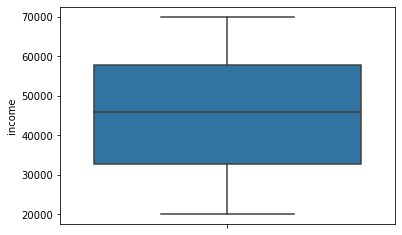

In [15]:
sns.boxplot(y = df.income)

<AxesSubplot:ylabel='Density'>

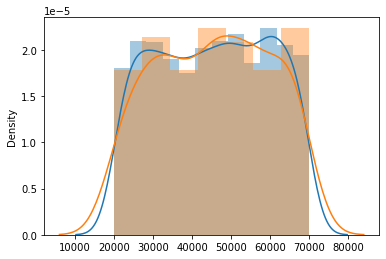

In [16]:
sns.distplot(x = df.loc[df.default == 0].income)
sns.distplot(x = df.loc[df.default == 1].income)

<AxesSubplot:xlabel='default', ylabel='income'>

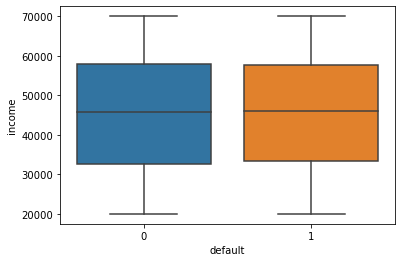

In [17]:
sns.boxplot(x = df.default, y = df.income )

Income doesnt seem relevant in predicting default. It seems to have the same distribution for those who defaulted as for those who didn't defaulted

## Age

In [18]:
df.age.describe()

count    1997.000000
mean       40.807559
std        13.624469
min       -52.423280
25%        28.990415
50%        41.317159
75%        52.587040
max        63.971796
Name: age, dtype: float64

<AxesSubplot:xlabel='default', ylabel='age'>

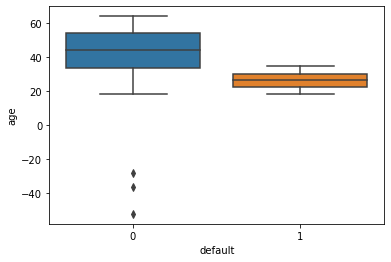

In [19]:
sns.boxplot(x = df.default, y = df.age )

In [20]:
#age seems to be relevant in predicting default

In [21]:
#I see that there are ages below zero

In [22]:
df.loc[df.age < 0]

,income,age,loan,default
15,50501.726689,-28.218361,3977.287432,0
21,32197.620701,-52.423280,4244.057136,0
26,63287.038908,-36.496976,9595.286289,0


In [23]:
#I assume that it is an error...these ages should be positive

In [24]:
df.age = df.age.apply(lambda x: x if x > 0 else abs(x))

In [25]:
df.age.describe() #no negative values anymore

count    1997.000000
mean       40.924874
std        13.267741
min        18.055189
25%        29.033679
50%        41.353171
75%        52.587040
max        63.971796
Name: age, dtype: float64

In [26]:
df.iloc[[15,21,26]]  #now they are fine

,income,age,loan,default
15,50501.726689,28.218361,3977.287432,0
21,32197.620701,52.423280,4244.057136,0
26,63287.038908,36.496976,9595.286289,0


In [27]:
df.age.isna().sum()

3

In [28]:
#3 rows have no values for the age variable

In [29]:
df.loc[df.age.isna()]

,income,age,loan,default
28,59417.805406,NaN,2082.625938,0
30,48528.852796,NaN,6155.784670,0
31,23526.302555,NaN,2862.010139,0


In [30]:
#as there are 2000 rows and these are the only three rows with missing values I decide to drop them

In [31]:
df.dropna(subset=["age"], inplace=True)

In [32]:
df.shape

(1997, 4)

In [33]:
df.age.isna().sum()  #no NAs anymore

0

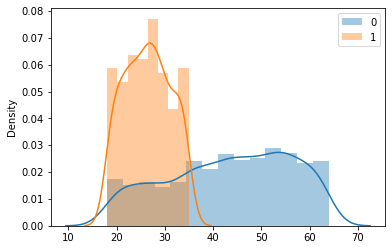

In [34]:
sns.distplot(x = df.loc[df.default == 0].age, label = 0)
sns.distplot(x = df.loc[df.default == 1].age, label= 1)
plt.legend()

#again...age seems relevant in predicting default

## LOAN

In [35]:
df.loan.describe()

count     1997.000000
mean      4445.487716
std       3046.792457
min          1.377630
25%       1936.813257
50%       3977.287432
75%       6440.861434
max      13766.051239
Name: loan, dtype: float64

<AxesSubplot:ylabel='loan'>

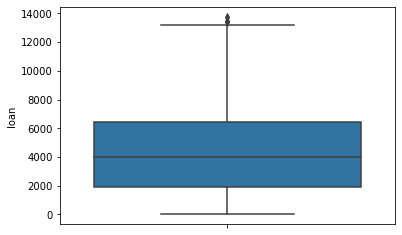

In [36]:
sns.boxplot(y = df.loan)

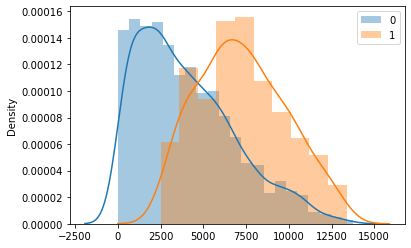

In [37]:
sns.distplot(x = df.loc[df.default == 0].loan, label = 0)
sns.distplot(x = df.loc[df.default == 1].loan, label= 1)
plt.legend()

In [38]:
#loan seems to be relevant too in predicting default

<AxesSubplot:xlabel='default', ylabel='loan'>

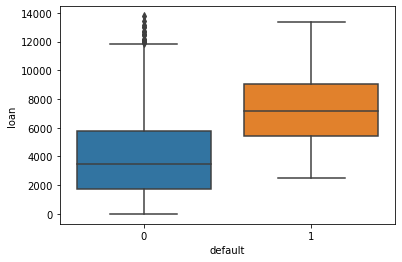

In [39]:
sns.boxplot(x = df.default, y = df.loan )

There are some potential outliers among those who didn't default....at the same time their values is still reasonable so I leave them

I will first try predicting default using two variables only: AGE and LOAN. Income doesn't seem to be relevant so I decide not to use it for the moment

<AxesSubplot:xlabel='loan', ylabel='Density'>

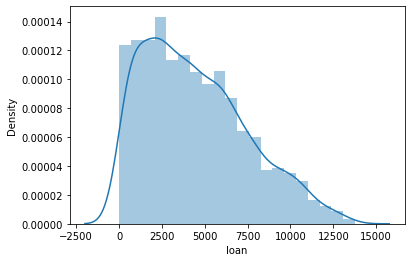

In [40]:
sns.distplot(df.loan)

In [41]:
# the loan variable is strongly skewed to the right

In [42]:
df.loan.skew()

0.6234859627391015

<AxesSubplot:xlabel='loan', ylabel='Density'>

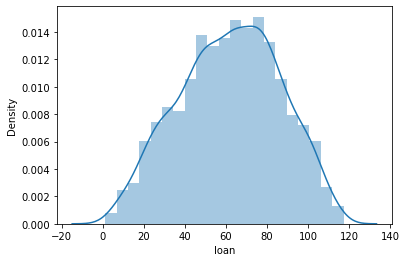

In [43]:
sns.distplot(np.sqrt(df.loan))

In [44]:
df["transformed_loan"] = np.sqrt(df.loan)

By applying a transformation the loan even looks more nomrally distirbuted (even if still not normally distributed).
I will use the transformed variable in my models

In [45]:
# Are the data balanced?

In [46]:
df.default.value_counts(normalize=True)

0    0.858287
1    0.141713
Name: default, dtype: float64

Data look a bit unbalanced...I will try not to undersample/oversample first...If results are not good I will try making the 2 classes more balanced

# Steps:
1. train/test split
2. make pipeline that scales the two variables as they have different scales
3. apply GridSearch with cross validation to find the best model and the best parameters
4. evaluate results (confusion matrix, ROC curve, decision boundary)

In [47]:
X = df[["age","transformed_loan" ]]
y = df.default

In [48]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 123, stratify = y)

# LOGISTIC REGRESSION 

In [49]:
logistic = LogisticRegression()

param_grid = {"logisticregression__C": [1]}

scaler = StandardScaler()

In [50]:
pipe_logistic = make_pipeline(scaler, logistic)

In [51]:
grid_logistic = GridSearchCV(pipe_logistic, param_grid, cv = 10, scoring="accuracy")

In [52]:
grid_logistic.fit(X_train, y_train)

GridSearchCV(cv=10,
             estimator=Pipeline(steps=[('standardscaler', StandardScaler()),
                                       ('logisticregression',
                                        LogisticRegression())]),
             param_grid={'logisticregression__C': [1]}, scoring='accuracy')

In [53]:
grid_logistic.best_estimator_

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('logisticregression', LogisticRegression(C=1))])

In [54]:
y_pred_logistic = grid_logistic.predict(X_test)

In [55]:
print("The training accuracy is %.2f" %grid_logistic.score(X_train, y_train))
print("The test accuracy is %.2f" %grid_logistic.score(X_test, y_test))

The training accuracy is 0.92
The test accuracy is 0.92


In [56]:
print("The test recall is %.2f" %recall_score(y_test, y_pred_logistic))
print("The test precision is %.2f" %precision_score(y_test, y_pred_logistic))

The test recall is 0.61
The test precision is 0.80


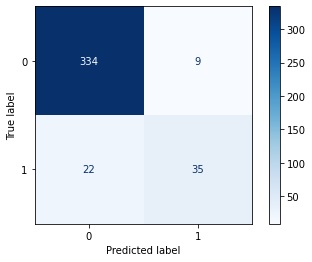

In [57]:
plot_confusion_matrix(grid_logistic, X_test, y_test, cmap=plt.cm.Blues)

Text(0.5, 1.0, 'Logistic Regression classifier ROC')

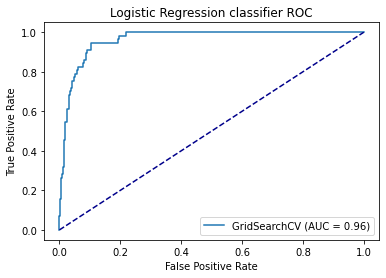

In [58]:
plot_roc_curve(grid_logistic, X_test, y_test)
plt.plot([0, 1], [0, 1], color='darkblue', linestyle='--')
plt.title("Logistic Regression classifier ROC")

In [59]:
X_train_log = np.array(X_train)
y_train_log = np.array(y_train)

Text(0.5, 1.0, 'Logistic_regression decision boundary')

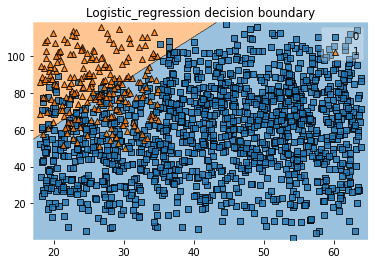

In [60]:
plot_decision_regions(X_train_log, y_train_log, clf=grid_logistic, legend=1)
plt.title("Logistic_regression decision boundary")

In [61]:
import statsmodels.api as sm
logit_model=sm.Logit(y,X)
result=logit_model.fit()
print(result.summary())

Optimization terminated successfully.
         Current function value: 0.182376
         Iterations 9
                           Logit Regression Results                           
Dep. Variable:                default   No. Observations:                 1997
Model:                          Logit   Df Residuals:                     1995
Method:                           MLE   Df Model:                            1
Date:                Thu, 22 Jul 2021   Pseudo R-squ.:                  0.5531
Time:                        14:58:58   Log-Likelihood:                -364.20
converged:                       True   LL-Null:                       -814.90
Covariance Type:            nonrobust   LLR p-value:                4.911e-198
                       coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------
age                 -0.2368      0.013    -17.764      0.000      -0.263      -0.211
transformed

# KNN

In [62]:
knn = KNeighborsClassifier()

param_grid_knn = {"kneighborsclassifier__n_neighbors": [1,2,3,4,5,6,7,8,9,10], "kneighborsclassifier__weights": ["uniform", "distance"], "kneighborsclassifier__p": [1,2]}

In [63]:
pipe_knn = make_pipeline(scaler, knn)

In [64]:
grid_knn = GridSearchCV(pipe_knn, param_grid = param_grid_knn, cv = 10, scoring="accuracy")

In [65]:
grid_knn.fit(X_train, y_train)

GridSearchCV(cv=10,
             estimator=Pipeline(steps=[('standardscaler', StandardScaler()),
                                       ('kneighborsclassifier',
                                        KNeighborsClassifier())]),
             param_grid={'kneighborsclassifier__n_neighbors': [1, 2, 3, 4, 5, 6,
                                                               7, 8, 9, 10],
                         'kneighborsclassifier__p': [1, 2],
                         'kneighborsclassifier__weights': ['uniform',
                                                           'distance']},
             scoring='accuracy')

In [66]:
grid_knn.best_estimator_

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('kneighborsclassifier',
                 KNeighborsClassifier(n_neighbors=6, p=1))])

In [67]:
y_pred_knn = grid_knn.predict(X_test)

In [68]:
print("The training accuracy is %.2f" %grid_knn.score(X_train, y_train))
print("The test accuracy is %.2f" %grid_knn.score(X_test, y_test))

The training accuracy is 0.94
The test accuracy is 0.93


In [69]:
print("The test recall is %.2f" %recall_score(y_test, y_pred_knn))
print("The test precision is %.2f" %precision_score(y_test, y_pred_knn))

The test recall is 0.61
The test precision is 0.85


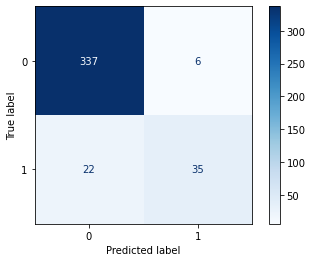

In [70]:
plot_confusion_matrix(grid_knn, X_test, y_test, cmap=plt.cm.Blues)

Text(0.5, 1.0, 'KNN classifier ROC')

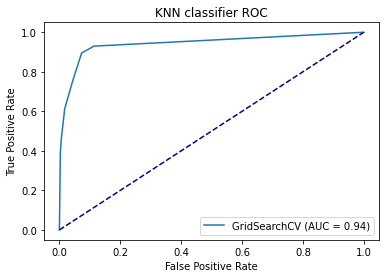

In [71]:
plot_roc_curve(grid_knn, X_test, y_test)
plt.plot([0, 1], [0, 1], color='darkblue', linestyle='--')
plt.title("KNN classifier ROC")

Text(0.5, 1.0, 'KNN decision boundary')

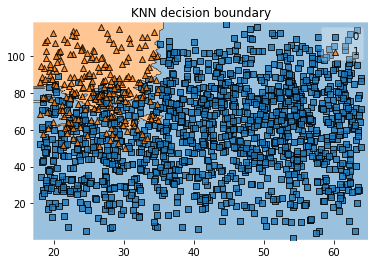

In [72]:
plot_decision_regions(X_train_log, y_train_log, clf=grid_knn, legend=1)
plt.title("KNN decision boundary")

# DECISION TREE

In [73]:
decisionTree = DecisionTreeClassifier()

param_grid_decisionTree = {"decisiontreeclassifier__max_depth": [1,2,3,4,5], "decisiontreeclassifier__min_samples_split": [2,5,10,15,20], "decisiontreeclassifier__min_samples_leaf": [5,10,15,20]}

In [74]:
pipe_decisionTree = make_pipeline(scaler, decisionTree )

In [75]:
grid_decisionTree = GridSearchCV(pipe_decisionTree, param_grid = param_grid_decisionTree, cv = 10, scoring="accuracy")

In [76]:
grid_decisionTree.fit(X_train, y_train)

GridSearchCV(cv=10,
             estimator=Pipeline(steps=[('standardscaler', StandardScaler()),
                                       ('decisiontreeclassifier',
                                        DecisionTreeClassifier())]),
             param_grid={'decisiontreeclassifier__max_depth': [1, 2, 3, 4, 5],
                         'decisiontreeclassifier__min_samples_leaf': [5, 10, 15,
                                                                      20],
                         'decisiontreeclassifier__min_samples_split': [2, 5, 10,
                                                                       15,
                                                                       20]},
             scoring='accuracy')

In [77]:
grid_decisionTree.best_estimator_

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('decisiontreeclassifier',
                 DecisionTreeClassifier(max_depth=3, min_samples_leaf=5))])

In [78]:
y_pred_decisionTree = grid_decisionTree.predict(X_test)

In [79]:
print("The training accuracy is %.2f" %grid_decisionTree.score(X_train, y_train))
print("The test accuracy is %.2f" %grid_decisionTree.score(X_test, y_test))

The training accuracy is 0.94
The test accuracy is 0.94


In [80]:
print("The test recall is %.2f" %recall_score(y_test, y_pred_decisionTree))
print("The test precision is %.2f" %precision_score(y_test, y_pred_decisionTree))

The test recall is 0.65
The test precision is 0.88


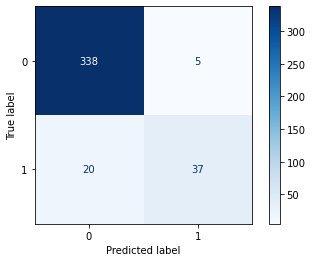

In [81]:
plot_confusion_matrix(grid_decisionTree, X_test, y_test, cmap=plt.cm.Blues)

Text(0.5, 1.0, 'Decision Tree classifier ROC')

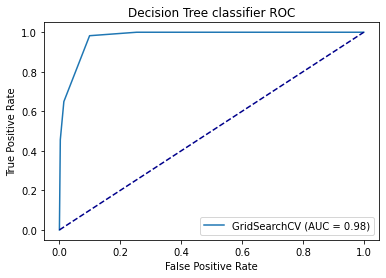

In [82]:
plot_roc_curve(grid_decisionTree, X_test, y_test)
plt.plot([0, 1], [0, 1], color='darkblue', linestyle='--')
plt.title("Decision Tree classifier ROC")

In [83]:
text_representation = tree.export_text(grid_decisionTree.best_estimator_[1])
print(text_representation)

|--- feature_0 <= -0.43
|   |--- feature_1 <= 0.62
|   |   |--- feature_1 <= -0.33
|   |   |   |--- class: 0
|   |   |--- feature_1 >  -0.33
|   |   |   |--- class: 0
|   |--- feature_1 >  0.62
|   |   |--- feature_1 <= 1.02
|   |   |   |--- class: 1
|   |   |--- feature_1 >  1.02
|   |   |   |--- class: 1
|--- feature_0 >  -0.43
|   |--- class: 0



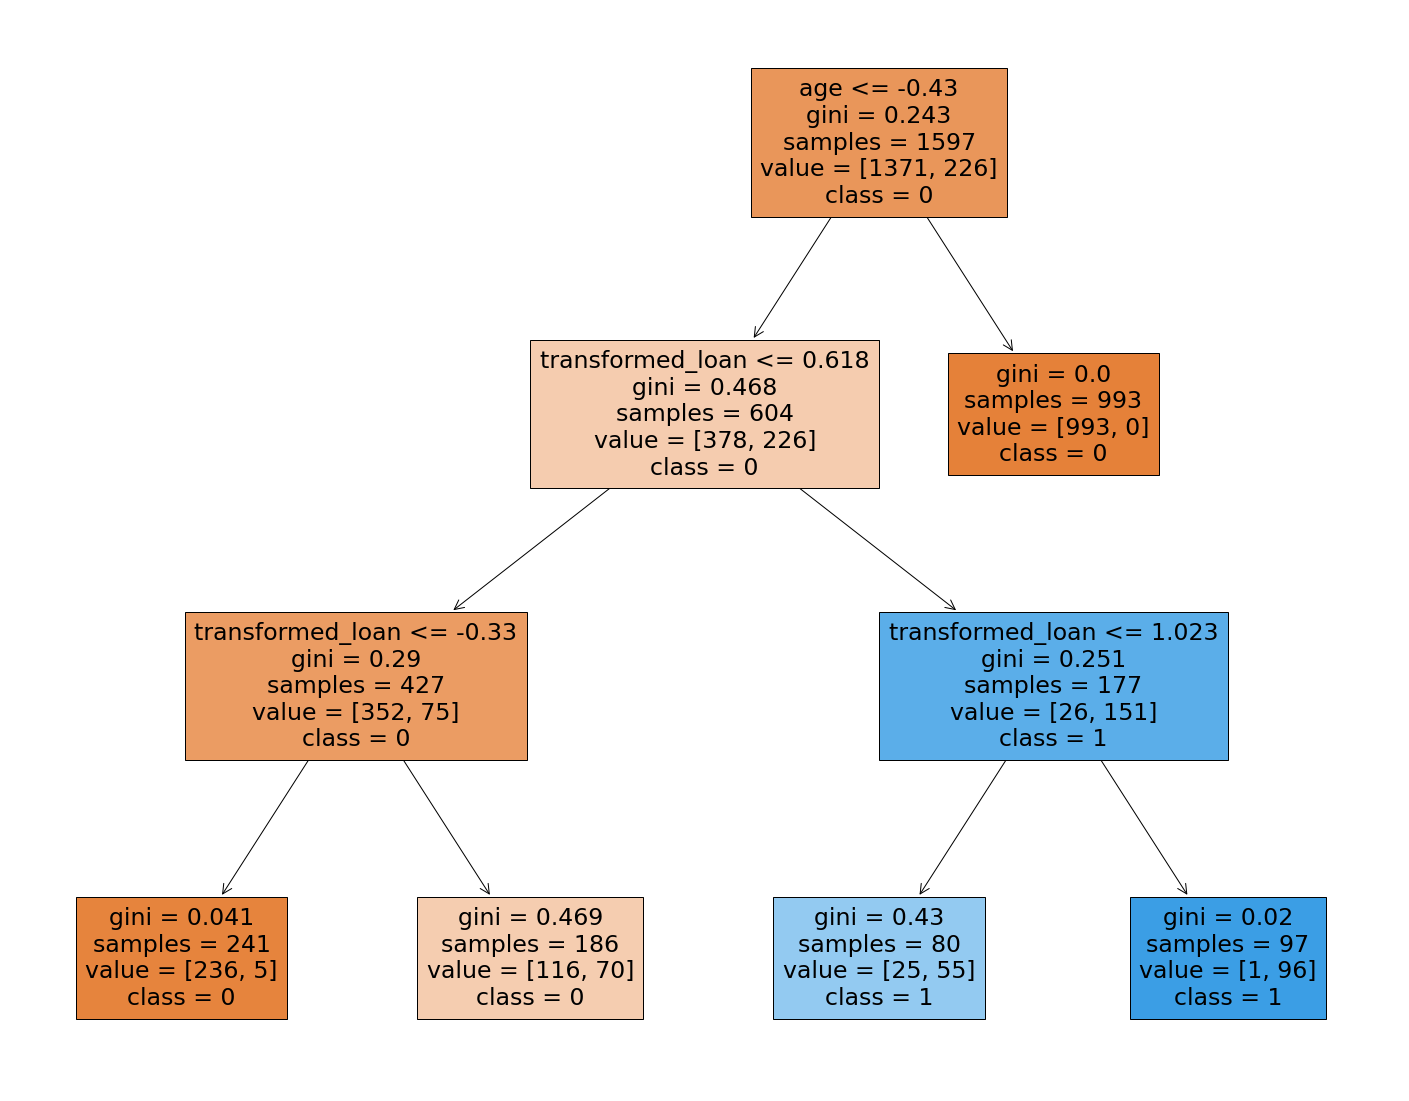

In [84]:
fig = plt.figure(figsize=(25,20))
_ = tree.plot_tree(grid_decisionTree.best_estimator_[1], 
                   feature_names= X.columns,  
                   class_names=["0", "1"],
                   filled=True)

Text(0.5, 1.0, 'Decision_Tree decision boundary')

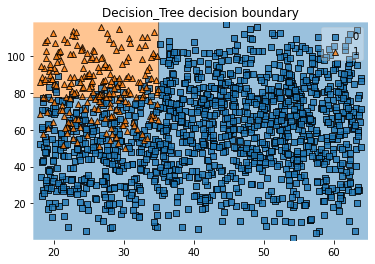

In [85]:
plot_decision_regions(X_train_log, y_train_log, clf=grid_decisionTree, legend=1)
plt.title("Decision_Tree decision boundary")

# RANDOM FOREST

In [86]:
randomForest = RandomForestClassifier()

param_grid_random = {"randomforestclassifier__n_estimators": [70,80,80,100],"randomforestclassifier__max_depth": [2,3,4,5]}

In [87]:
pipe_randomForest = make_pipeline(scaler, randomForest )

In [88]:
grid_randomForest = GridSearchCV(pipe_randomForest, param_grid = param_grid_random, cv = 10, scoring="accuracy")

In [89]:
grid_randomForest.fit(X_train, y_train)

GridSearchCV(cv=10,
             estimator=Pipeline(steps=[('standardscaler', StandardScaler()),
                                       ('randomforestclassifier',
                                        RandomForestClassifier())]),
             param_grid={'randomforestclassifier__max_depth': [2, 3, 4, 5],
                         'randomforestclassifier__n_estimators': [70, 80, 80,
                                                                  100]},
             scoring='accuracy')

In [90]:
grid_randomForest.best_estimator_

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('randomforestclassifier',
                 RandomForestClassifier(max_depth=4))])

In [91]:
y_pred_randomForest = grid_randomForest.predict(X_test)

In [92]:
print("The training accuracy is %.2f" %grid_randomForest.score(X_train, y_train))
print("The test accuracy is %.2f" %grid_randomForest.score(X_test, y_test))

The training accuracy is 0.94
The test accuracy is 0.94


In [93]:
print("The test recall is %.2f" %recall_score(y_test, y_pred_randomForest))
print("The test precision is %.2f" %precision_score(y_test, y_pred_randomForest))

The test recall is 0.67
The test precision is 0.86


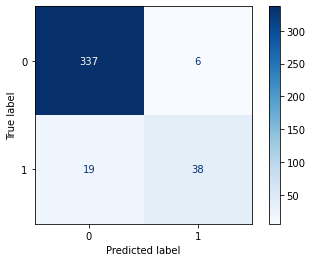

In [94]:
plot_confusion_matrix(grid_randomForest, X_test, y_test, cmap=plt.cm.Blues)

Text(0.5, 1.0, 'Random Forest classifier ROC')

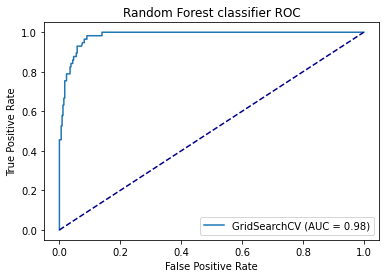

In [95]:
plot_roc_curve(grid_randomForest, X_test, y_test)
plt.plot([0, 1], [0, 1], color='darkblue', linestyle='--')
plt.title("Random Forest classifier ROC")

Text(0.5, 1.0, 'Decision_Tree decision boundary')

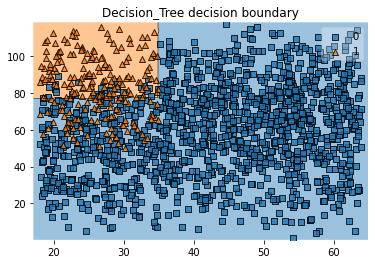

In [96]:
plot_decision_regions(X_train_log, y_train_log, clf=grid_randomForest, legend=1)
plt.title("Decision_Tree decision boundary")

# ADABOOST

In [97]:
adaboost = AdaBoostClassifier()

param_adaBoost = {"adaboostclassifier__n_estimators": [70,80,80,100]}

In [98]:
pipe_adaBoost = make_pipeline(scaler, adaboost )

In [99]:
grid_adaBoost = GridSearchCV(pipe_adaBoost, param_grid = param_adaBoost, cv = 10, scoring="accuracy")

In [100]:
grid_adaBoost.fit(X_train, y_train)

GridSearchCV(cv=10,
             estimator=Pipeline(steps=[('standardscaler', StandardScaler()),
                                       ('adaboostclassifier',
                                        AdaBoostClassifier())]),
             param_grid={'adaboostclassifier__n_estimators': [70, 80, 80, 100]},
             scoring='accuracy')

In [101]:
grid_adaBoost.best_estimator_

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('adaboostclassifier', AdaBoostClassifier(n_estimators=80))])

In [102]:
y_pred_adaBoost = grid_adaBoost.predict(X_test)

In [103]:
print("The training accuracy is %.2f" %grid_adaBoost.score(X_train, y_train))
print("The test accuracy is %.2f" %grid_adaBoost.score(X_test, y_test))

The training accuracy is 0.95
The test accuracy is 0.93


In [104]:
print("The test recall is %.2f" %recall_score(y_test, y_pred_adaBoost))
print("The test precision is %.2f" %precision_score(y_test, y_pred_adaBoost))

The test recall is 0.70
The test precision is 0.78


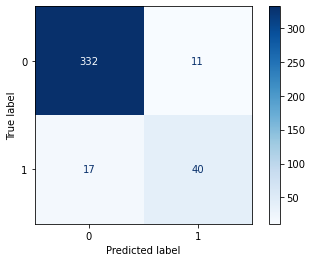

In [105]:
plot_confusion_matrix(grid_adaBoost, X_test, y_test, cmap=plt.cm.Blues)

Text(0.5, 1.0, 'AdaBoost classifier ROC')

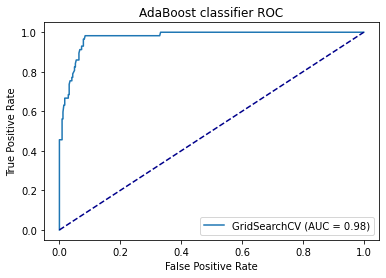

In [106]:
plot_roc_curve(grid_adaBoost, X_test, y_test)
plt.plot([0, 1], [0, 1], color='darkblue', linestyle='--')
plt.title("AdaBoost classifier ROC")

Text(0.5, 1.0, 'AdaBoost decision boundary')

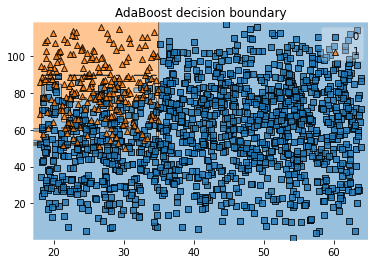

In [107]:
plot_decision_regions(X_train_log, y_train_log, clf=grid_adaBoost, legend=1)
plt.title("AdaBoost decision boundary")

# SVC

In [108]:
svc = SVC()

param_SVC = {"svc__C": [0.8,1,1.1], "svc__kernel": ["linear", "poly", "rbf", "sigmoid", "precomputed"]}

In [109]:
pipe_SVC = make_pipeline(scaler, svc )

In [110]:
grid_SVC = GridSearchCV(pipe_SVC, param_grid = param_SVC, cv = 10, scoring="accuracy")

In [111]:
grid_SVC.fit(X_train, y_train)

GridSearchCV(cv=10,
             estimator=Pipeline(steps=[('standardscaler', StandardScaler()),
                                       ('svc', SVC())]),
             param_grid={'svc__C': [0.8, 1, 1.1],
                         'svc__kernel': ['linear', 'poly', 'rbf', 'sigmoid',
                                         'precomputed']},
             scoring='accuracy')

In [112]:
grid_SVC.best_estimator_

Pipeline(steps=[('standardscaler', StandardScaler()), ('svc', SVC(C=0.8))])

In [113]:
y_pred_SVC = grid_SVC.predict(X_test)

In [114]:
print("The training accuracy is %.2f" %grid_SVC.score(X_train, y_train))
print("The test accuracy is %.2f" %grid_SVC.score(X_test, y_test))

The training accuracy is 0.93
The test accuracy is 0.94


In [115]:
print("The test recall is %.2f" %recall_score(y_test, y_pred_SVC))
print("The test precision is %.2f" %precision_score(y_test, y_pred_SVC))

The test recall is 0.68
The test precision is 0.85


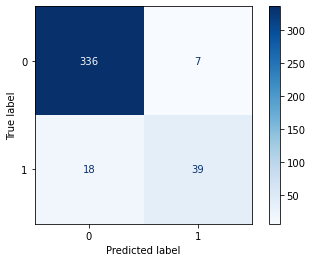

In [116]:
plot_confusion_matrix(grid_SVC, X_test, y_test, cmap=plt.cm.Blues)

Text(0.5, 1.0, 'SVC classifier ROC')

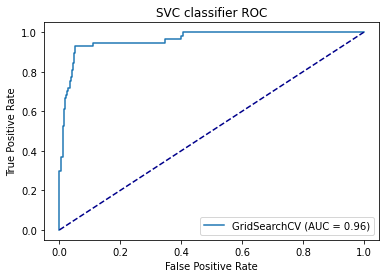

In [117]:
plot_roc_curve(grid_SVC, X_test, y_test)
plt.plot([0, 1], [0, 1], color='darkblue', linestyle='--')
plt.title("SVC classifier ROC")

Text(0.5, 1.0, 'SVC decision boundary')

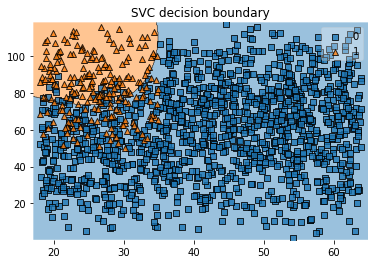

In [118]:
plot_decision_regions(X_train_log, y_train_log, clf=grid_SVC, legend=1)
plt.title("SVC decision boundary")

# MLP

In [119]:
mlp = MLPClassifier()

param_mlp = {"mlpclassifier__hidden_layer_sizes": [70,80,90,100], "mlpclassifier__activation": ['identity', 'logistic', 'tanh', 'relu']}

In [120]:
pipe_mlp = make_pipeline(scaler, mlp )

In [121]:
grid_mlp = GridSearchCV(pipe_mlp, param_grid = param_mlp, cv = 10, scoring="accuracy")

In [122]:
grid_mlp.fit(X_train, y_train)

GridSearchCV(cv=10,
             estimator=Pipeline(steps=[('standardscaler', StandardScaler()),
                                       ('mlpclassifier', MLPClassifier())]),
             param_grid={'mlpclassifier__activation': ['identity', 'logistic',
                                                       'tanh', 'relu'],
                         'mlpclassifier__hidden_layer_sizes': [70, 80, 90,
                                                               100]},
             scoring='accuracy')

In [123]:
grid_mlp.best_estimator_

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('mlpclassifier', MLPClassifier(hidden_layer_sizes=80))])

In [124]:
y_pred_mlp = grid_mlp.predict(X_test)

In [125]:
print("The training accuracy is %.2f" %grid_mlp.score(X_train, y_train))
print("The test accuracy is %.2f" %grid_mlp.score(X_test, y_test))

The training accuracy is 0.93
The test accuracy is 0.94


In [126]:
print("The test recall is %.2f" %recall_score(y_test, y_pred_mlp))
print("The test precision is %.2f" %precision_score(y_test, y_pred_mlp))

The test recall is 0.72
The test precision is 0.82


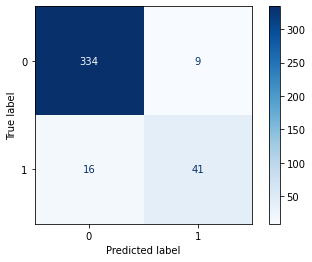

In [127]:
plot_confusion_matrix(grid_mlp, X_test, y_test, cmap=plt.cm.Blues)

Text(0.5, 1.0, 'MLP classifier ROC')

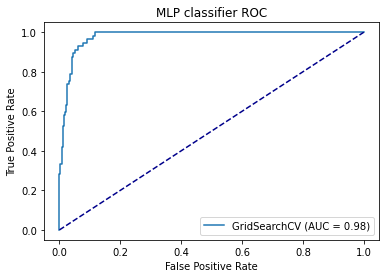

In [128]:
plot_roc_curve(grid_mlp, X_test, y_test)
plt.plot([0, 1], [0, 1], color='darkblue', linestyle='--')
plt.title("MLP classifier ROC")

Text(0.5, 1.0, 'MLP decision boundary')

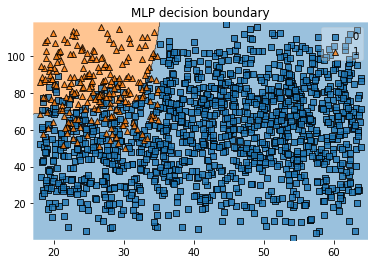

In [129]:
plot_decision_regions(X_train_log, y_train_log, clf=grid_mlp, legend=1)
plt.title("MLP decision boundary")

## COCHRAN'S Q TEST

In [135]:
q, p_value = cochrans_q(np.array(y_test), 
                        np.array(y_pred_adaBoost), 
                        np.array(y_pred_decisionTree),
                        np.array(y_pred_knn),
                        np.array(y_pred_logistic),
                        np.array(y_pred_mlp),
                        np.array(y_pred_randomForest),
                        np.array(y_pred_SVC))

print('Q: %.3f' % q)
print('p-value: %.3f' % p_value)

Q: 5.278
p-value: 0.509


In [137]:
#As the p values is greater than 0.05 I can't reject the null hypothesis meaning that the models are similar in terms of accuracies (no differences in their performances)